In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
os.chdir("../..")

DATA_DIR = os.environ["DATA_DIR"]
OUTPUT_DIR = os.environ["OUTPUT_DIR"]

In [3]:
# copied and pasted from prov-gigapath implementation
import numpy as np
import torch


def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate(
            [np.zeros([1, embed_dim]), pos_embed], axis=0
        )
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(
        embed_dim // 2, grid[0]
    )  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(
        embed_dim // 2, grid[1]
    )  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.0
    omega = 1.0 / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum("m,d->md", pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def coords_to_pos(coords, tile_size: int = 256):
    """
    This function is used to convert the coordinates to the positional indices

    Arguments:
    ----------
    coords: torch.Tensor
        The coordinates of the patches, of shape [N, L, 2]
    output: torch.Tensor
        The positional indices of the patches, of shape [N, L]
    """
    slide_ngrids = 1000
    coords_ = torch.floor(coords / tile_size)
    pos = coords_[..., 0] * slide_ngrids + coords_[..., 1]
    return pos.long()

In [4]:
tile_embed_dir = os.path.join(OUTPUT_DIR, "uni/tile_embeddings_sorted")
fnames = os.listdir(tile_embed_dir)
tile_embed_paths = [
    os.path.join(tile_embed_dir, fname)
    for fname in fnames
    if fname.endswith(".pkl")
]

In [5]:
import pickle

idx = np.random.randint(0, len(tile_embed_paths) - 1)
with open(tile_embed_paths[idx], "rb") as f:
    embeds = pickle.load(f)

In [6]:
# load gigapath positional embeds and get positional data, then get corresponding embeds
gp_pos = get_2d_sincos_pos_embed(1024, 1000, False)
pos_from_coords = coords_to_pos(embeds["coords"])
gp_pos_emb = gp_pos[pos_from_coords, :]

In [7]:
from models.pos_embedding import PositionalEmbedding

# load my implementation of the gigapath embeds and get embeds
my_pos = PositionalEmbedding(1024, 1000)
my_pos_emb = my_pos.forward(embeds["pos"].to(torch.long))

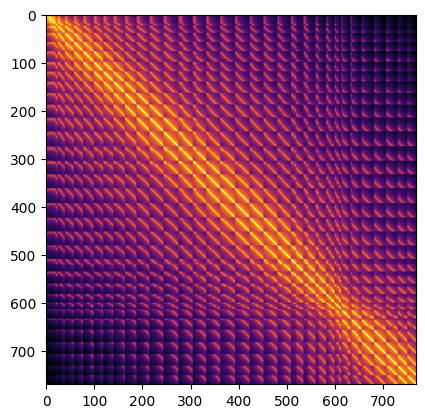

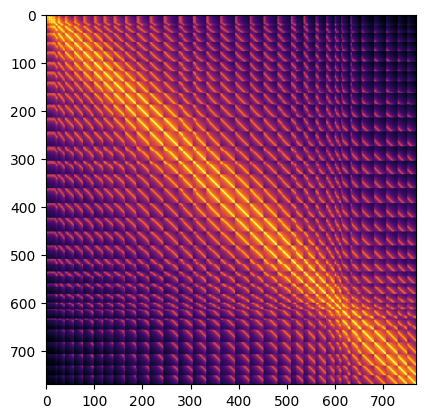

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

# plot similarity to view structure of embeddings
similarity = gp_pos_emb @ gp_pos_emb.T
plt.imshow(similarity, cmap="inferno")
plt.show()
plt.close()

similarity = my_pos_emb @ my_pos_emb.T
plt.imshow(similarity, cmap="inferno")
plt.show()
plt.close()

In [9]:
# do the whole thing again but with contiguous coordinates
x = torch.arange(0, 20).repeat_interleave(100)
y = torch.arange(0, 20).repeat(100)
xy = torch.stack((x, y), dim=1)

In [10]:
pos_from_coords = coords_to_pos(xy * 256)
gp_pos_emb = gp_pos[pos_from_coords, :]
my_pos_emb = my_pos(xy)

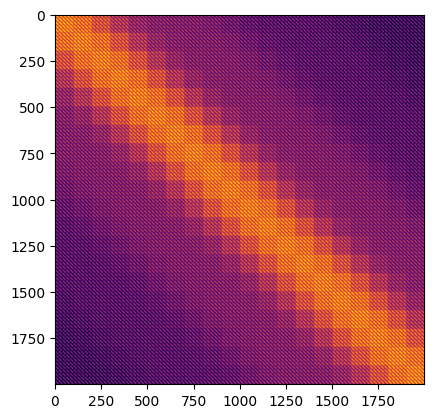

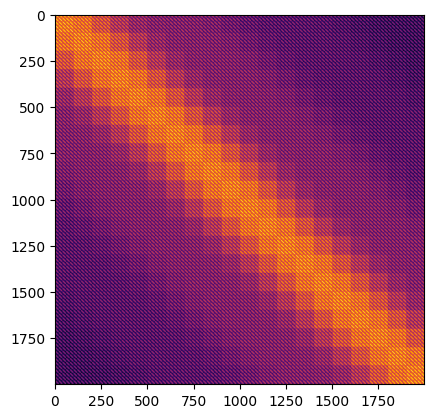

In [11]:
similarity = gp_pos_emb @ gp_pos_emb.T
plt.imshow(similarity, cmap="inferno")
plt.show()
plt.close()

similarity = my_pos_emb @ my_pos_emb.T
plt.imshow(similarity, cmap="inferno")
plt.show()
plt.close()